# Bagged decision trees vs random forest

In this notebook we will build these two types of models. The goal is to compare them with the out-of-bag test score. We will be using a standard dataset concerning housing prices in California in the 90's. This is a regression problem. 

If possible, we would also like to obtain a quantification of *feature importance* with respect to the regression variable.

## 0. Loading the dataset and setting constants

In [16]:
from sklearn.datasets import fetch_california_housing
import numpy as np

bunch = fetch_california_housing(as_frame = True)
X_raw = np.asanyarray(bunch["data"])
y_raw = np.asanyarray(bunch["target"])
features = bunch.feature_names

I create a meta-validation dataset because... I might tune some hyperparameters

In [17]:
from sklearn.model_selection import train_test_split
X, X_val, y, y_val = train_test_split(X_raw, y_raw, test_size = 0.2)
print(f"Dataset contains {X.size :d} observations")

Dataset contains 132096 observations


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)
print(f"{X_train.size:d} training observations.")
print(f"{X_test.size:d} validation observations.")

105672 training observations.
26424 validation observations.


In [19]:
number_of_estimators = 100 # number of trees to be used in each case

## 1. Bagged decision tree

We build the bagged decision tree with the class `BaggingRegressor` from `sklearn.ensemble`. The bagged regressor model will then train `number_of_estimators`, and since by default the optional argument `bootstrap` is set to `True` it will create `number_of_estimators` samples of the same size using sampling-with-replacement.

The final model, being a regressor, will then predict using the average of the response of the `number_of_estimators` trained trees.

In [20]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

bagged_model = BaggingRegressor(DecisionTreeRegressor(), oob_score = True, n_estimators = number_of_estimators, n_jobs = -1)

In [21]:
bagged_model.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100,
                 n_jobs=-1, oob_score=True)

The bagged model keeps track of which observations where used to train each tree. This allows for a powerful method for evaluating the model's accuracy: predict for an observation in the training dataset averaging only over those trees that did not see that particular observation during the training phase.

It is very similar to evaluating with a completely unseen sample, the validation set we separated earlier.

In [22]:
print(f"OOB score: {bagged_model.oob_score_}")
print(f"Test score: {bagged_model.score(X_test, y_test)}")

OOB score: 0.7993603421561015
Test score: 0.8074696484343507


The `BaggingRegressor` class however does not allow to extract feature importance, so we lose some of the interpretability of the simple decision tree regressor.

## 2. Building the random forest

We will now build a random forest model. The main difference with respect to the bagged regression tree is that, even though we will also be training `number_of_estimators` trees, each will only be able to use in building each node only a subset of the variables. 

This has the benefit of decorrelating the trees: if some feature is extremely correlated with the target variable, most of the trees will use it in building the first node, and we could lose sight of less-but-still important predictor variables!

In [23]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(n_estimators = number_of_estimators , max_features = "sqrt", oob_score = True, n_jobs = -1)

forest_model.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_jobs=-1, oob_score=True)

In [24]:
print(f"OOB score: {forest_model.oob_score_}")
print(f"Test score: {forest_model.score(X_test, y_test)}")

OOB score: 0.8047780649862677
Test score: 0.8134056104482879


For `number_of_estimators=100` the random forest has slightly better results than the bagged regression trees. We will later on test this upon variation of the number of estimators.

### 2.1 Extracting feature importance

In [31]:
max_importance = max(forest_model.feature_importances_)

print("Relative importances of each feature relative to maximum")
for k in range(len(features)):
    print(f"{features[k]}: {forest_model.feature_importances_[k] / max_importance*100:.2f}")

Relative importances of each feature relative to maximum
MedInc: 100.00
HouseAge: 17.08
AveRooms: 35.01
AveBedrms: 13.60
Population: 10.73
AveOccup: 37.35
Latitude: 40.84
Longitude: 41.47


## 3. Iterating it!

We will now systematically compared random forest models with bagged decision trees by varying the number of trees in each ensemble.

In [28]:
number_of_trees = [10,20,30,50,100,200]
forest_oob_scores = []
forest_scores = []
bagged_oob_scores = []
bagged_scores = []

for number_of_estimators in number_of_trees:
    bagged_model = BaggingRegressor(DecisionTreeRegressor(), oob_score = True, n_estimators = number_of_estimators, n_jobs = -1)
    bagged_model.fit(X_train, y_train)

    bagged_oob_scores.append(bagged_model.oob_score_)
    bagged_scores.append(bagged_model.score(X_test, y_test))



    forest_model = RandomForestRegressor(n_estimators = number_of_estimators , max_features = "sqrt", oob_score = True, n_jobs = -1)

    forest_model.fit(X_train, y_train)


    forest_oob_scores.append(forest_model.oob_score_)
    forest_scores.append(forest_model.score(X_test, y_test))



/home/jesus/.conda/envs/tf-gpu2/lib/python3.7/site-packages/sklearn/ensemble/_bagging.py:1164: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/home/jesus/.conda/envs/tf-gpu2/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/home/jesus/.conda/envs/tf-gpu2/lib/python3.7/site-packages/sklearn/ensemble/_bagging.py:1164: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/home/jesus/.conda/envs/tf-gpu2/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB 

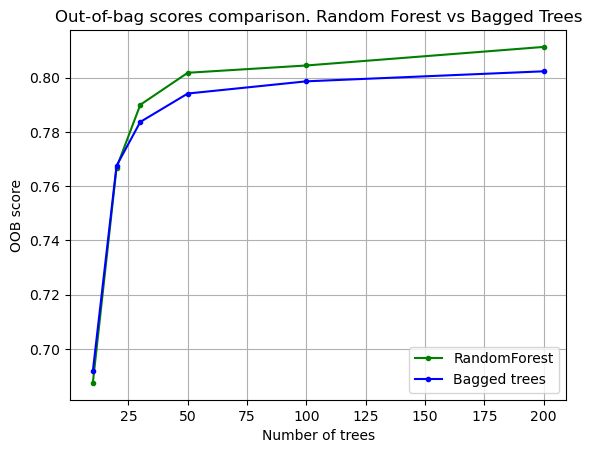

In [29]:
import matplotlib.pyplot as plt

plt.plot(number_of_trees, forest_oob_scores,'.-g',label='RandomForest')
plt.plot(number_of_trees, bagged_oob_scores,'.-b',label = 'Bagged trees')
plt.grid(True)
plt.xlabel('Number of trees')
plt.ylabel('OOB score')
plt.legend()
plt.title("Out-of-bag scores comparison. Random Forest vs Bagged Trees")
plt.show()


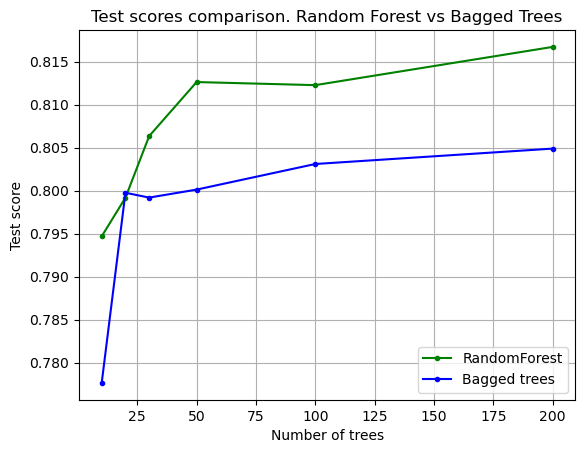

In [30]:
import matplotlib.pyplot as plt

plt.plot(number_of_trees, forest_scores,'.-g',label='RandomForest')
plt.plot(number_of_trees, bagged_scores,'.-b',label = 'Bagged trees')
plt.grid(True)
plt.xlabel('Number of trees')
plt.ylabel('Test score')
plt.legend()
plt.title("Test scores comparison. Random Forest vs Bagged Trees")
plt.show()

We can see that random forests outperform decision trees. They seem to gain more information from the dataset!